# Introduction
This jupyter notebook is accompanied with [MBTI Twitter personality classsification](https://www.github.com/sahilsehwag/twitter-mbti-personality-classifier) project. This notebook is created to easily explore our dataset, perform analysis and perform modelling. To use the final classifier refer to [README.md](https://www.github.com/sahilsehwag/twitter-mbti-personality-classifier) file of this project. Use [main.py](https://github.com/sahilsehwag/twitter-mbti-personality-classifier/blob/master/main.py) to perform personality classification on any twitter user.
<br>
### Dataset
The [dataset](https://github.com/sahilsehwag/twitter-mbti-personality-classifier/blob/master/personality-test.csv) on which this classifier is trained, contains around 50 posts per user about 8000 users with their *MBTI*
personality type known. Dataset is provided in the repo itself [personality-test.csv](https://github.com/sahilsehwag/twitter-mbti-personality-classifier/blob/master/personality-test.csv).
<br>
Few features of dataset are:
* Posts of more than 8000 users.
* Last 50 posts per user, each entry is separated by '|||'.

### Challenges
The main challenge with this particular dataset is the imbalance in dataset. The dataset is hugely imbalanced. I have tackled this problem by training a model for each characteristic pair. There is imbalance in different characteristic pair like IE pair. Different solutions to this problem are stated in below sections.

# Setup

## Helper Methods

In [1]:
#printing on single line
def printl(msg):
    sys.stdout.write("\r" + str(msg))
    sys.stdout.flush()


#pickler
def save(filepath, obj):
    with open(filepath, 'wb') as file:
        pickle.dump(obj, file, pickle.HIGHEST_PROTOCOL)


#unpickler
def load(filepath):
    return pickle.load(filepath)

## Imports

In [2]:
import sys
import re
import string
import pickle
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer

from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, recall_score, f1_score
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.externals import joblib

from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.svm import SVC

import tweepy

## Loading Dataset
I will add one column for each MBTI characteristic pair, since we will be training independent classifier model 
for each pair independently. The reason for this is because of imbalance present in our dataset. For example posts of 
introverts are very large as compared to extroverts. To understand and visualize this go to [**EDA**](#EDA-(Exploratory-Data-Analysis&#41;) section.

In [3]:
%%time
df = pd.read_csv('personality-test.csv')
df['ie'] = df.type
df['ns'] = df.type
df['ft'] = df.type
df['pj'] = df.type

for i, t in enumerate(df.type):
    if 'I' in t:
        df.ie[i] = 'I'
    elif 'E' in t:
        df.ie[i] = 'E'
        
    if 'N' in t:
        df.ns[i] = 'N'
    elif 'S' in t:
        df.ns[i] = 'S'
        
    if 'F' in t:
        df.ft[i] = 'F'
    elif 'T' in t:
        df.ft[i] = 'T'
        
    if 'P' in t:
        df.pj[i] = 'P'
    elif 'J' in t:
        df.pj[i] = 'J'


posts = df.posts.values
yIE = df.ie.values
yNS = df.ns.values
yFT = df.ft.values
yPJ = df.pj.values
y = df.type

CPU times: user 4.89 s, sys: 158 ms, total: 5.05 s
Wall time: 5.63 s


## Preprocessing
NOTE: this phase might take some time to execute due to computationaly expensive operations

In [4]:
#regular expressions for tokenization
regexes = [
    #urls
    #r'http[s]?://(?:[a-z]|[0-9]|[$-_@.&amp;+]|[!*\(\),]|(?:%[0-9a-f][0-9a-f]))+',
    
    #html
    #r'<[^>]+>',
    
    #punctuation
    r'(?:(\w+)\'s)',
    
    r'(?:\s(\w+)\.+\s)',
    r'(?:\s(\w+),+\s)',
    r'(?:\s(\w+)\?+\s)',
    r'(?:\s(\w+)!+\s)',
    
    r'(?:\'+(\w+)\'+)',
    r'(?:"+(\w+)"+)',
    r'(?:\[+(\w+)\]+)',
    r'(?:{+(\w+)}+)',
    r'(?:\(+(\w+))',
    r'(?:(\w+)\)+)',

    #words containing numbers & special characters & punctuation
    r'(?:(?:(?:[a-zA-Z])*(?:[0-9!"#$%&\'()*+,\-./:;<=>?@\[\\\]^_`{|}~])+(?:[a-zA-Z])*)+)',
    
    #pure words
    r'([a-zA-Z]+)',
    
    #numbers
    #r'(?:(?:\d+,?)+(?:\.?\d+)?)',

    #emoticons
    #r"""(?:[:=;][oO\-]?[D\)\]\(\]/\\OpP])""",

    #other words
    #r'(?:[\w_]+)',

    #anything else
    #r'(?:\S)'
]

#compiling regular expression
regex = re.compile(r'(?:'+'|'.join(regexes)+')', re.VERBOSE | re.IGNORECASE)


def preprocess(documents):
    lemmatizer = WordNetLemmatizer()
    stemmer = PorterStemmer()
    
    #fetching list of stopwords
    punctuation = list(string.punctuation)
    swords = stopwords.words('english') + ['amp'] + ['monday', 'tuesday', 'wednesday', 'thursday', 'friday', 'saturday', 'sunday', 'january', 'feburary', 'march', 'april', 'may', 'june', 'july', 'august', 'september', 'october', 'november', 'december',  'mon', 'tue', 'wed', 'thu', 'fri', 'sat', 'sun',  'jan', 'feb', 'mar', 'apr', 'may', 'jun' 'jul', 'aug', 'sep', 'oct', 'nov', 'dec', 'tommorow', 'today', 'yesterday'] + ['mr', 'mrs']


    processed_documents = []
    for i,document in enumerate(documents):
        printl('{0}/{1}'.format(i+1, len(documents)))
        
        #tokenization
        tokens = regex.findall(document)

        #skipping useless tokens
        t_regex = re.compile(r"[^a-zA-Z]")
        document = []
        
        for token in tokens:
            token = np.array(token)
            token = np.unique(token[token != ''])
            
            if len(token) > 0:
                token = token[0].lower()
            else:
                continue
                
            if re.search(t_regex, token) == None and token not in swords:
                token = lemmatizer.lemmatize(token)
                document.append(token)
                
        document = ' '.join(document)

        #skipping
        if len(document) > 0:
            processed_documents.append(document)

    print()
    return np.array(processed_documents)

In [5]:
%%time
# posts = preprocess(posts)

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 7.87 µs


# Processing

I am only using document matrix, using TF-IDF weighing scheme will actually result in model's performance degradation. I think the reason is because our document are relatively small in nature due to small size nature of tweets.

In [6]:
%%time
# creating document frequency matrix
cv = CountVectorizer().fit(posts)
X = cv.transform(posts)

CPU times: user 21.5 s, sys: 395 ms, total: 21.9 s
Wall time: 22.5 s


### Splitting Dataset

In [7]:
# splitting dataset into training and testing dataset
xIETrain, xIETest, yIETrain, yIETest = train_test_split(X, yIE)
xNSTrain, xNSTest, yNSTrain, yNSTest = train_test_split(X, yNS)
xFTTrain, xFTTest, yFTTrain, yFTTest = train_test_split(X, yFT)
xPJTrain, xPJTest, yPJTrain, yPJTest = train_test_split(X, yPJ)
xTrain, xTest, yTrain, yTest = train_test_split(X, y)

# EDA (Exploratory Data Analysis)

As we can see that our dataset has disproportionate data. Due to this **heavy unbalance** in our dataset we will
be training our classifiers independently for each characteristic pair. This unbalance makes it very difficult 
to work with different algorithms, specially probability based models. To look at this, refer to cells below in this section. For analysing the effect of this balance in machine learning algorithms using conventional approaches look at [result analysis section](#Analysing-our-Models-Results).

This problem is called **Imbalanced Classification Problem**. Generally there are two approaches to tackle this kind of problem:
* **Sampling**<br>
    There are different sampling techniques to tackle this problem, we will be discussing few of them.
    * *Random Sampling*
    * *SMOTE*
    * *Modified SMOTE*
* **Ensemble Methods**

I will be using type of *random sampling* technique called **undersampling**, In this approach we will randomly remove our sample instances from majority class until the size of majority class instances are equal to minority class instances.

INFP    1832
INFJ    1470
INTP    1304
INTJ    1091
ENTP     685
ENFP     675
ISTP     337
ISFP     271
ENTJ     231
ISTJ     205
ENFJ     190
ISFJ     166
ESTP      89
ESFP      48
ESFJ      42
ESTJ      39
Name: type, dtype: int64


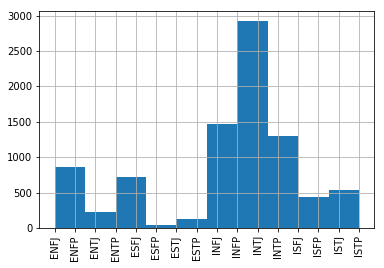

In [8]:
print(df.type.value_counts())
df.type.hist(xrot=90)
plt.show()

In cell below we can see that there is great **unbalance** in **Introvert/Extrovert** and **Intuition/Sensing** pairs. Whereas **Feeling/Thinking** and **Perception/Judgment** pairs are quite *balanced*. Although I have created trained models for each pair. Only last 2 pairs are somewhat reliable in predicting MBTI type. So it is
not advised to depend on first 2 pairs i.e. **IE** and **NS** pairs. For analysis of results of various trained models is present below in [result analysis section](#Analysing-our-Models-Results)

I    6676
E    1999
Name: ie, dtype: int64

N    7478
S    1197
Name: ns, dtype: int64

F    4694
T    3981
Name: ft, dtype: int64

P    5241
J    3434
Name: pj, dtype: int64



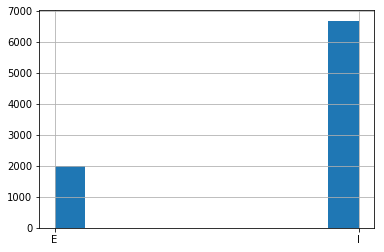

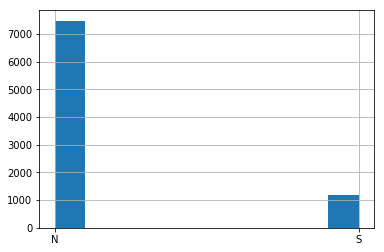

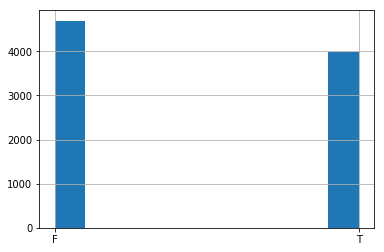

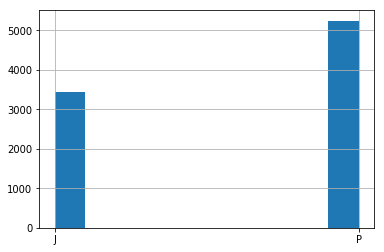

In [9]:
print(df.ie.value_counts(), end='\n\n')
print(df.ns.value_counts(), end='\n\n')
print(df.ft.value_counts(), end='\n\n')
print(df.pj.value_counts(), end='\n\n')

df.ie.hist(); plt.show()
df.ns.hist(); plt.show()
df.ft.hist(); plt.show()
df.pj.hist(); plt.show()

# Modelling

### Training our Models

In [10]:
%%time
%time model = MultinomialNB().fit(xTrain, yTrain)
%time ieModel = MultinomialNB().fit(xIETrain, yIETrain)
%time nsModel = MultinomialNB().fit(xNSTrain, yNSTrain)
%time ftModel = MultinomialNB().fit(xFTTrain, yFTTrain)
%time pjModel = MultinomialNB().fit(xPJTrain, yPJTrain)

CPU times: user 251 ms, sys: 58.7 ms, total: 310 ms
Wall time: 345 ms
CPU times: user 61.6 ms, sys: 17.1 ms, total: 78.6 ms
Wall time: 81.5 ms
CPU times: user 57.3 ms, sys: 8.2 ms, total: 65.5 ms
Wall time: 66.8 ms
CPU times: user 64.7 ms, sys: 10 ms, total: 74.7 ms
Wall time: 75.8 ms
CPU times: user 58.8 ms, sys: 11.8 ms, total: 70.5 ms
Wall time: 82.8 ms
CPU times: user 499 ms, sys: 107 ms, total: 606 ms
Wall time: 659 ms


### Testing our Models

As we can see our models performed relatively well despite the weaknesses present in our dataset. Although this accuracy is **superficial** in the cases of first 2 models i.e. **IE** and **NS**. The reason being that these are heavily biased towards a single characteristic value. This will be evident in [result analysis section](#Analysing-our-Models-Results) below.
Our accuracy is just high because our most of data is belonging to one instance. Introvert for example in IE model.

In [11]:
print(model.score(xTest, yTest))
print(ieModel.score(xIETest, yIETest))
print(nsModel.score(xNSTest, yNSTest))
print(ftModel.score(xFTTest, yFTTest))
print(pjModel.score(xPJTest, yPJTest))

0.345320424159
0.787920700784
0.833102812356
0.792992162287
0.713692946058


Instead of accuracy, which is a bad metric for imbalance dataset, we will be using **recall** and **f1 score**, to measure our model performance.

In [57]:
#minority classes
print('MINORITY CLASSES:')
print(recall_score(yIETest, ieModel.predict(xIETest), pos_label='E'))
print(recall_score(yNSTest, nsModel.predict(xNSTest), pos_label='S'))
print(recall_score(yFTTest, ftModel.predict(xFTTest), pos_label='T'))
print(recall_score(yPJTest, pjModel.predict(xPJTest), pos_label='J'), end='\n\n')

#majority classes
print('MAJORITY CLASSES:')
print(recall_score(yIETest, ieModel.predict(xIETest), pos_label='I'))
print(recall_score(yNSTest, nsModel.predict(xNSTest), pos_label='N'))
print(recall_score(yFTTest, ftModel.predict(xFTTest), pos_label='F'))
print(recall_score(yPJTest, pjModel.predict(xPJTest), pos_label='P'))

MINORITY CLASSES:
0.157464212679
0.0838709677419
0.717346938776
0.469150174622

MAJORITY CLASSES:
0.971428571429
0.958041958042
0.855340622372
0.874045801527


In [58]:
#minority classes
print('MINORITY CLASSES:')
print(f1_score(yIETest, ieModel.predict(xIETest), pos_label='E'))
print(f1_score(yNSTest, nsModel.predict(xNSTest), pos_label='S'))
print(f1_score(yFTTest, ftModel.predict(xFTTest), pos_label='T'))
print(f1_score(yPJTest, pjModel.predict(xPJTest), pos_label='J'), end='\n\n')

#majority classes
print('MAJORITY CLASSES:')
print(f1_score(yIETest, ieModel.predict(xIETest), pos_label='I'))
print(f1_score(yNSTest, nsModel.predict(xNSTest), pos_label='N'))
print(f1_score(yFTTest, ftModel.predict(xFTTest), pos_label='F'))
print(f1_score(yPJTest, pjModel.predict(xPJTest), pos_label='P'))

MINORITY CLASSES:
0.250814332248
0.125603864734
0.75795148248
0.564821303434

MAJORITY CLASSES:
0.876476906552
0.907747196738
0.819170358437
0.786671246994


For better analysis or testing of our model, we will be using classification report to see **recall** which is measure of how much right predictions we make per characteristic. *Accuracy* is bad *classification metric* in our case due to **imbalanced classification problem**. Recall will give us better insight.

In [13]:
print(classification_report(yTest, model.predict(xTest)), end='\n\n')

             precision    recall  f1-score   support

       ENFJ       0.00      0.00      0.00        50
       ENFP       0.50      0.01      0.02       160
       ENTJ       0.00      0.00      0.00        55
       ENTP       0.40      0.01      0.02       159
       ESFJ       0.00      0.00      0.00         9
       ESFP       0.00      0.00      0.00        12
       ESTJ       0.00      0.00      0.00        12
       ESTP       0.00      0.00      0.00        23
       INFJ       0.37      0.43      0.40       378
       INFP       0.30      0.89      0.45       459
       INTJ       0.71      0.11      0.20       283
       INTP       0.45      0.43      0.44       328
       ISFJ       0.00      0.00      0.00        37
       ISFP       0.00      0.00      0.00        73
       ISTJ       0.00      0.00      0.00        45
       ISTP       0.00      0.00      0.00        86

avg / total       0.35      0.35      0.26      2169




/Users/jaat/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


As it can be seen for first 2 pairs ie **IE** and **NS** the *recall* score is very low for minority classes. In first pair the recall score for "extroverts" is **0.13** which is amazingly bad.

In [14]:
print(classification_report(yIETest, ieModel.predict(xIETest)), end='\n\n')
print(classification_report(yNSTest, nsModel.predict(xNSTest)), end='\n\n')
print(classification_report(yFTTest, ftModel.predict(xFTTest)), end='\n\n')
print(classification_report(yPJTest, pjModel.predict(xPJTest)), end='\n\n')

             precision    recall  f1-score   support

          E       0.62      0.16      0.25       489
          I       0.80      0.97      0.88      1680

avg / total       0.76      0.79      0.74      2169


             precision    recall  f1-score   support

          N       0.86      0.96      0.91      1859
          S       0.25      0.08      0.13       310

avg / total       0.77      0.83      0.80      2169


             precision    recall  f1-score   support

          F       0.79      0.86      0.82      1189
          T       0.80      0.72      0.76       980

avg / total       0.79      0.79      0.79      2169


             precision    recall  f1-score   support

          J       0.71      0.47      0.56       859
          P       0.72      0.87      0.79      1310

avg / total       0.71      0.71      0.70      2169




### Cross Validation

To get actual performance of our models, I am using **KFold cross validation** with *k=10* to get actual performance. These values will be **pickled** along with models, so that these can be used in scripts to allow users to see
performance and reliability of each model corresponding to their characteristic pair.

In [38]:
scores = []

scores.append(cross_val_score(estimator=model, cv=10, X=X, y=y, scoring='accuracy'))
scores.append(cross_val_score(estimator=ieModel, cv=10, X=X, y=LabelEncoder().fit_transform(yIE), scoring='recall'))
scores.append(cross_val_score(estimator=nsModel, cv=10, X=X, y=LabelEncoder().fit_transform(yNS), scoring='recall'))
scores.append(cross_val_score(estimator=ftModel, cv=10, X=X, y=LabelEncoder().fit_transform(yFT), scoring='recall'))
scores.append(cross_val_score(estimator=pjModel, cv=10, X=X, y=LabelEncoder().fit_transform(yPJ), scoring='recall'))

#prining mean and standard deviations for each model
for score in scores:
    print(score.mean())
    print(score.std(), end='\n\n')

0.376724638516
0.0118203235415

0.952665658189
0.0105624310118

0.119474789916
0.0278256538239

0.742022140779
0.0161272773425

0.857852780807
0.00990676530416



### Analysing our Models Results

In case of this model where we are predicting MBTI type using all characteristics together. It can be seen heavy bias in results of trained model.

INFP    459
INFJ    378
INTP    328
INTJ    283
ENFP    160
ENTP    159
ISTP     86
ISFP     73
ENTJ     55
ENFJ     50
ISTJ     45
ISFJ     37
ESTP     23
ESTJ     12
ESFP     12
ESFJ      9
Name: type, dtype: int64

INFP    1358
INFJ     446
INTP     311
INTJ      45
ENTP       5
ENFP       4
dtype: int64


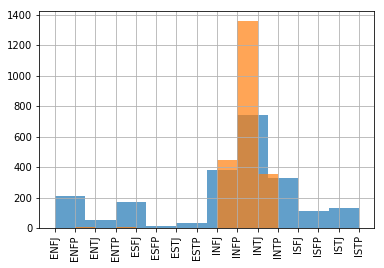

In [21]:
print(pd.Series(yTest).value_counts(), end='\n\n')
print(pd.Series(model.predict(xTest)).value_counts())

pd.Series(yTest).hist(xrot=90, alpha=0.7)
pd.Series(model.predict(xTest)).hist(xrot=90, alpha=0.7)
plt.show()

In next 2 models ie **IE** and **NS** models we can see that class distribution is heavily biased, this accounts for high accuracy in our results for these specific models.

I    1680
E     489
dtype: int64

I    2044
E     125
dtype: int64

             precision    recall  f1-score   support

          E       0.62      0.16      0.25       489
          I       0.80      0.97      0.88      1680

avg / total       0.76      0.79      0.74      2169



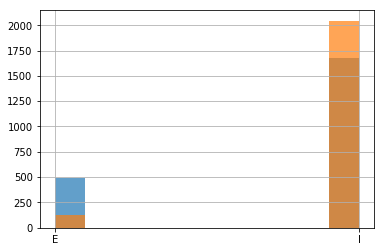

In [22]:
print(pd.Series(yIETest).value_counts(), end='\n\n')
print(pd.Series(ieModel.predict(xIETest)).value_counts(), end='\n\n')
print(classification_report(y_pred=ieModel.predict(xIETest), y_true=yIETest))

pd.Series(yIETest).hist(alpha=0.7)
pd.Series(ieModel.predict(xIETest)).hist(alpha=0.7)
plt.show()

N    1859
S     310
dtype: int64

N    2065
S     104
dtype: int64


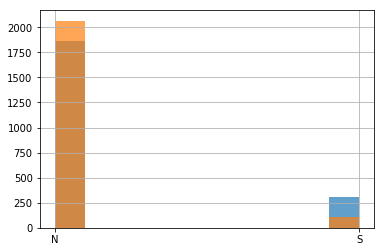

In [23]:
print(pd.Series(yNSTest).value_counts(), end='\n\n')
print(pd.Series(nsModel.predict(xNSTest)).value_counts())

pd.Series(yNSTest).hist(alpha=0.7)
pd.Series(nsModel.predict(xNSTest)).hist(alpha=0.7)
plt.show()

F    1189
T     980
dtype: int64

F    1294
T     875
dtype: int64


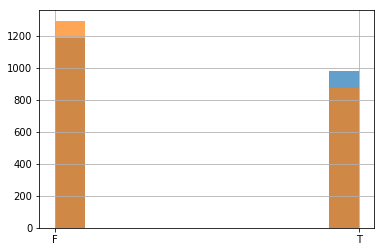

In [24]:
print(pd.Series(yFTTest).value_counts(), end='\n\n')
print(pd.Series(ftModel.predict(xFTTest)).value_counts())

pd.Series(yFTTest).hist(alpha=0.7)
pd.Series(ftModel.predict(xFTTest)).hist(alpha=0.7)
plt.show()

P    1310
J     859
dtype: int64

P    1601
J     568
dtype: int64


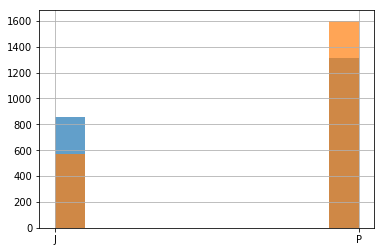

In [25]:
print(pd.Series(yPJTest).value_counts(), end='\n\n')
print(pd.Series(pjModel.predict(xPJTest)).value_counts())

pd.Series(yPJTest).hist(alpha=0.7)
pd.Series(pjModel.predict(xPJTest)).hist(alpha=0.7)
plt.show()

### Pickling our Models

In [ ]:
models = {
    'models': [model, ieModel, nsModel, ftModel, pjModel],
    'accuracies': accuracies,
    'usable': [False, False, False, True, True]
}
joblib.dump(models, 'models.pkl')

# Twitter

In [17]:
CONSUMER_KEY        = os.environ['TWITTER_CONSUMER_KEY']
CONSUMER_SECRET     = os.environ['TWITTER_CONSUMER_SECRET']
ACCESS_TOKEN        = os.environ['TWITTER_ACCESS_TOKEN']
ACCESS_TOKEN_SECRET = os.environ['TWITTER_ACCESS_TOKEN_SECRET']

AUTH = tweepy.OAuthHandler(CONSUMER_KEY, CONSUMER_SECRET)
AUTH.set_access_token(ACCESS_TOKEN, ACCESS_TOKEN_SECRET)

api = tweepy.API(AUTH)

# Bootstrapping

### Fetching Tweets
The username is the twitter handle of the target user without "@"

In [18]:
#getting user tweets
tweets = api.user_timeline('narendramodi', count=200)
tweets = [tweet.text for tweet in tweets]

### Procsssing Tweets

In [19]:
document = cv.transform([' '.join(tweets)])

### Predicting MBTI Personality

In [20]:
print(ieModel.predict(document))
print(nsModel.predict(document))
print(ftModel.predict(document))
print(pjModel.predict(document))

['I']
['N']
['T']
['J']
